In [135]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

In [136]:
def make_toy_batch(batchsize=2):
    img = torch.zeros(batchsize, 1, 256, 256)
    mask = torch.zeros_like(img)
    for b in range(batchsize):
        x = torch.randint(32, 255-32, [])
        y = torch.randint(32, 255-32, [])

        mask[b,:,y-16:y+16,x-16:x+16] = 1
        img[b,:,y-16:y+16,x-16:x+16] = torch.rand(1,1,32,32) > 0.8
    
    return img, mask

In [247]:
class MarchingSquares(nn.Module):
    def __init__(self):
        super().__init__()
        self.corner_points = np.array([[.5, -.5], [.5, .5], [-.5, .5], [-.5, -.5]], np.float32)[np.newaxis]
        self.register_buffer('coefficients', torch.Tensor([
            [ -1,  0,  1,  0,  0,  0,  0,  0],
            [  0, -1,  0,  1,  0,  0,  0,  0],
            [  0,  0,  0,  0, -1,  0,  1,  0],
            [  0,  0,  0,  0,  0, -1,  0,  1],
        ]).t().contiguous())

        SW, SE, NE, NW = range(4)

        self.first_segment = np.array([
            [-1, -1, -1, -1],
            [NW, SW, SE, SW],
            [SW, SE, NE, SE],
            [NW, SW, NE, SE],
            [SE, NE, NW, NE],
            [NW, SW, SE, SW],
            [SW, SE, NW, NE],
            [NW, SW, NW, NE],
            [NE, NW, SW, NW],
            [NE, NW, SE, SW],
            [SW, SE, NE, SE],
            [NE, NW, NE, SE],
            [SE, NE, SW, NW],
            [SE, NE, SE, SW],
            [SW, SE, SW, NW],
        ])
        self.second_segment = np.array([
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [SE, NE, NW, NE],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [SE, NE, NW, NE],
        ])

    def forward(self, coarse):
        # Replicate Padding ensures we don't create edges parallel to the border
        coarse = F.pad(coarse, [1, 1, 1, 1], mode='replicate').squeeze(1)
        nw = coarse[:, :-1, :-1]
        ne = coarse[:, :-1, 1:]
        sw = coarse[:, 1:, :-1]
        se = coarse[:, 1:, 1:]
        values = torch.stack([sw, se, ne, nw], dim=-1)

        # Indexing calculations done on cpu (easier, faster, and they don't need grad)
        cells = (values > 0).to('cpu', torch.bool).numpy()
        cellidx = (np.packbits(cells, axis=3, bitorder='big') >> 4).squeeze(3)

        E1B, E1Y, E1X = np.nonzero((cellidx > 0) & (cellidx < 15))
        E2B, E2Y, E2X = np.nonzero((cellidx == 0b1010) | (cellidx == 0b0101))
        cell_batch = np.hstack([E1B, E2B])
        '''
        reordered = np.argsort(cell_batch, kind='stable')
        cell_batch = cell_batch[reordered]
        '''
        edges_per_img = tuple(np.bincount(cell_batch, minlength=coarse.shape[0]))

        required_vals = np.concatenate([
            self.first_segment[cellidx[E1B, E1Y, E1X]],
            self.second_segment[cellidx[E2B, E2Y, E2X]]
        ], axis=0)# [reordered]

        required_vals = torch.from_numpy(required_vals).to(coarse.device, non_blocking=True)

        cell_y = np.hstack([E1Y, E2Y])# [reordered]
        cell_x = np.hstack([E1X, E2X])# [reordered]
        cell_yx = np.hstack([cell_y[:, np.newaxis], cell_x[:, np.newaxis]])

        cell_corners = torch.from_numpy(cell_yx[:, np.newaxis] + self.corner_points)
        cell_corners = cell_corners.to(coarse.device, torch.float32, non_blocking=True)

        cell_vals = values[cell_batch, cell_y, cell_x]

        double_idx = torch.stack([required_vals, required_vals], dim=2)
        final_vals = torch.gather(cell_vals, dim=1, index=required_vals).unsqueeze(2)
        final_corners = torch.gather(cell_corners, dim=1, index=double_idx)
        
        # layout: yl1, xl1, yu1, xu1, yl2, xl2, yu2, xu2
        coords = (final_vals * final_corners).view(-1, 8)
        vals = torch.stack([final_vals, final_vals], dim=2).view(-1, 8)

        # numerator = torch.matmul(coords, self.coefficients)
        # denominator = torch.matmul(vals, self.coefficients)
        # FIXME Should be all positive...
        
        print(cell_corners)
        # return numerator / denominator
        return torch.matmul(final_corners.reshape(-1, 8), self.coefficients) / 2

In [245]:
test_grid = torch.Tensor([[-1, 1]]).unsqueeze(0).unsqueeze(0)
q = MarchingSquares()(test_grid)

tensor(0.) tensor(0.5000) tensor(0.) tensor(0.5000)
tensor(0.) tensor(0.5000) tensor(0.) tensor(0.5000)


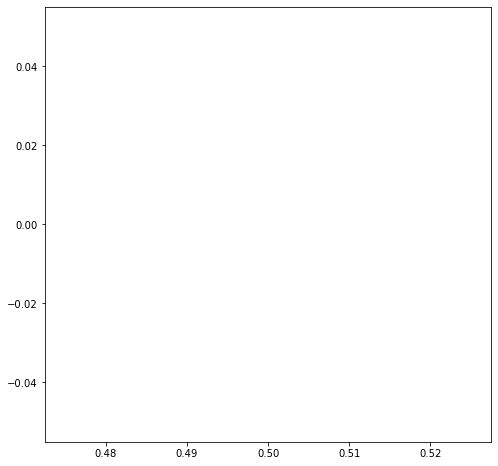

In [246]:
for sy, sx, ty, tx in q:
    print(sy, sx, ty, tx)
    plt.plot([sx, tx], [sy, ty])

In [158]:
class SnakeNet(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels=16):
        super().__init__()
        bc = base_channels

        # Backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, 2, stride=2),
            nn.Conv2d(1 * bc, 2 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(2 * bc, 3 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(3 * bc, 4 * bc, 2, stride=2), nn.Tanh(),
        )
        
        self.make_coarse = nn.Conv2d(4 * bc, 1, 1)
        self.marching_squares = MarchingSquares()

    def forward(self, x):
        features = self.backbone(x)
        coarse = self.make_coarse(features)

        # Do Marching squares
        locls = self.marching_squares(coarse)

        return (edges, edges_per_img), coarse, locls

In [159]:
net = SnakeNet(1, 1)
# opt = torch.optim.Adam(net.parameters(), 1e-3)
opt = torch.optim.SGD(net.parameters(), 1e-2, momentum=0.95, nesterov=True)

for i in range(500):
    img, mask = make_toy_batch()
    N, C, H, W = img.shape
    coarse_target = mask.view(N, C, H // 16, 16, W // 16, 16)
    coarse_target = coarse_target.transpose(3, 4)
    coarse_target = coarse_target.reshape(N, C, H // 16, W // 16, -1)
    coarse_target = coarse_target.max(dim=-1)[0]
    x, coarse, locls = net(img)

    coarse_loss = F.binary_cross_entropy_with_logits(coarse, coarse_target)
    opt.zero_grad()
    coarse_loss.backward()
    opt.step()
    if (i+1) % 100 == 0:
        print(coarse_loss.item())

print(img.shape, '->', coarse.shape)

0.15276765823364258
0.1519688069820404
0.13146476447582245
0.14903554320335388
0.1385943442583084
torch.Size([2, 1, 256, 256]) -> torch.Size([2, 1, 16, 16])


In [162]:
net.marching_squares(coarse)['cellidx']

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 

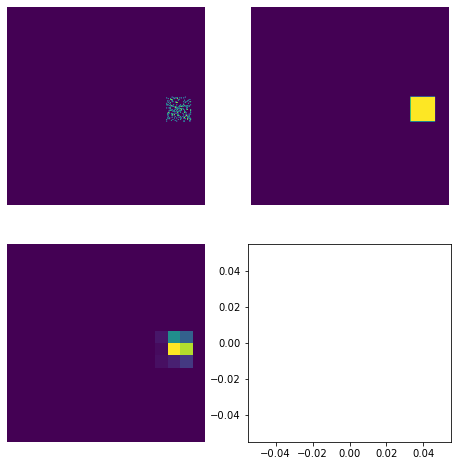

In [165]:
# edges, edges_per_img = x
# edges = torch.split(edges, edges_per_img)

figsize(8, 8)
plt.subplot(2, 2, 1)
plt.imshow(img[0,0])
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(mask[0,0])
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(coarse[0,0].detach())
plt.axis('off')
plt.subplot(2, 2, 4)
for sy, sx, ty, tx in edges[0]:
    plt.plot([sx, tx], [sy, ty])

In [115]:
locls.keys()

dict_keys(['self', 'coarse', 'nw', 'ne', 'sw', 'se', 'values', 'cells', 'cellidx', 'E1B', 'E1Y', 'E1X', 'E2B', 'E2Y', 'E2X', 'cell_batch', 'edges_per_img', 'required_vals', 'cell_y', 'cell_x', 'cell_yx', 'cell_corners', 'cell_vals', 'double_idx', 'final_vals', 'final_corners', 'coords', 'vals', 'numerator', 'denominator'])

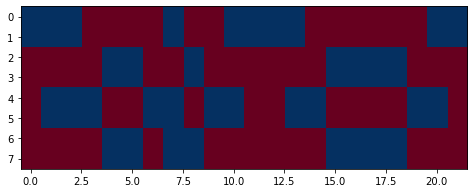

In [111]:
plt.imshow(locls['vals'].detach().T, vmin=-.1, vmax=.1, cmap='RdBu')